# Day 2: Pearson Correlation Coefficient vs. Lead Time

This notebook creates a plot for each observation source (GPCC, CHIRPS, MSWEP) showing the Pearson correlation coefficient for each lead time for each DCPP model. The significant coefficient values at 95th percentile level is shown as grey horizontal dashed lines. The same six panel format is used and explained in 00_DCPP_GPCC_visualisation.ipynb.

CanESM5
EC-Earth3
HadGEM3-GC31-MM
IPSL-CM6A-LR
MIROC6
MPI-ESM1-2-HR
NorCPM1
CanESM5
EC-Earth3
HadGEM3-GC31-MM
IPSL-CM6A-LR
MIROC6
MPI-ESM1-2-HR
NorCPM1
CanESM5
EC-Earth3
HadGEM3-GC31-MM
IPSL-CM6A-LR
MIROC6
MPI-ESM1-2-HR
NorCPM1


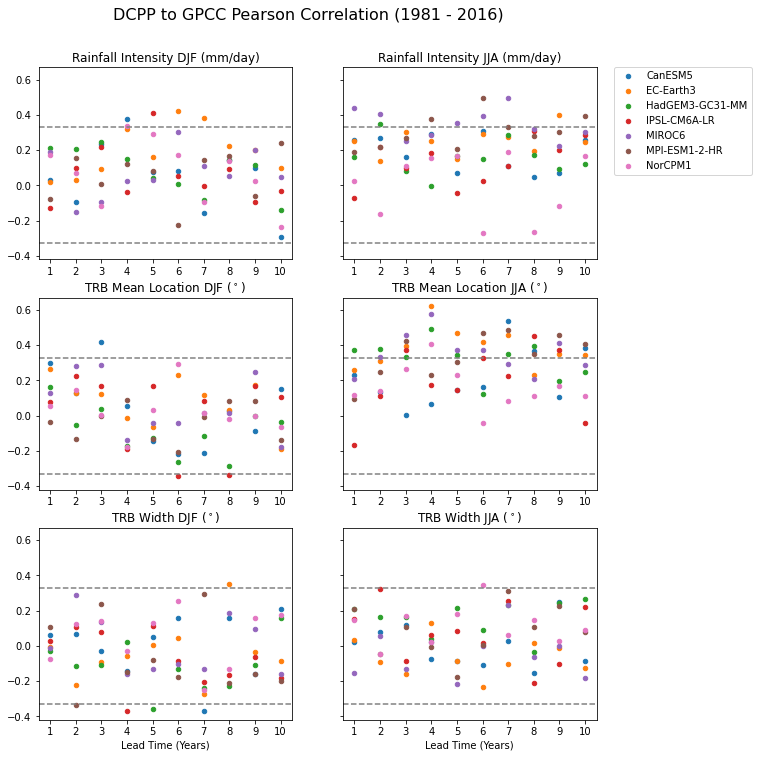

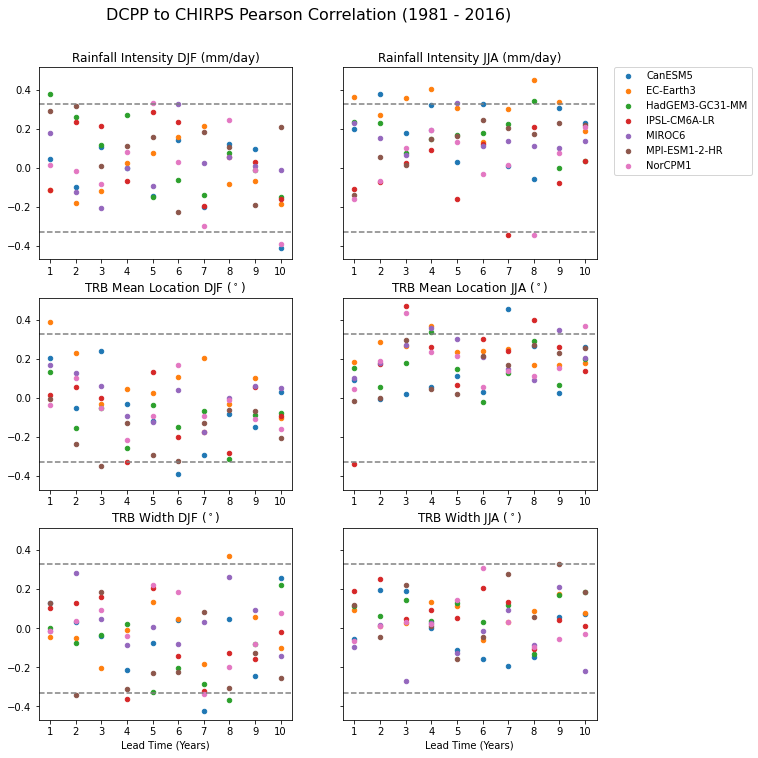

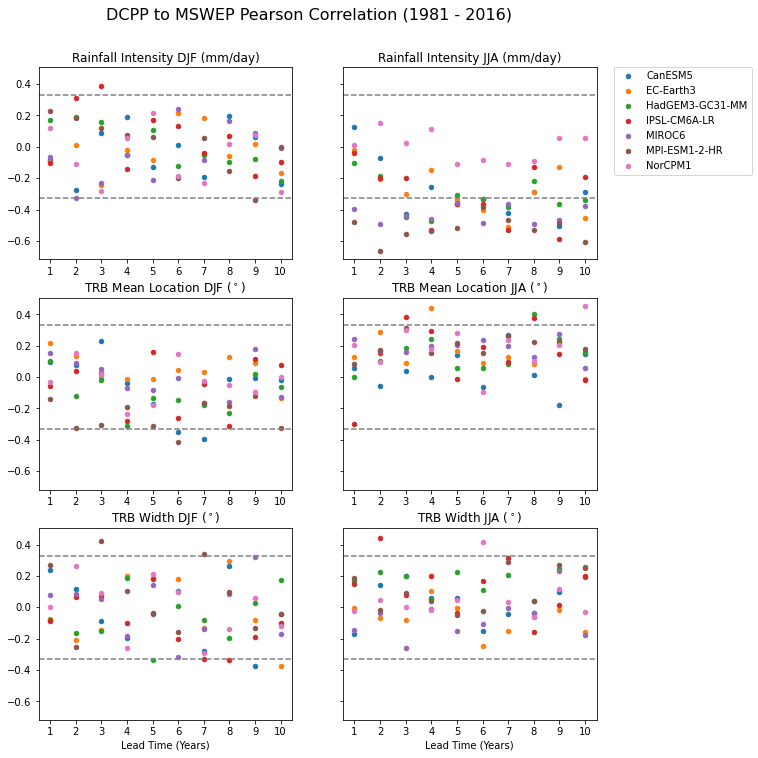

In [33]:
import numpy as np
import xarray as xr
import glob as glob
import matplotlib.pyplot as plt
from scipy.stats import t


def calc_r_crit(n):
    """
    :param int n: Number of data points used to calculate Pearson correlation coefficient
    :return tuple: Lower critical correlation coefficient, Upper critical correlation coefficient
    """
    t_upper = t.ppf(0.975, df=n-1)
    t_lower = t.ppf(0.025, df=n-1)
    # https://en.wikipedia.org/wiki/Pearson_correlation_coefficient#Testing_using_Student's_t-distribution
    r_crit_upper = t_upper / np.sqrt(n - 2 + t_upper**2)
    r_crit_lower = t_lower / np.sqrt(n - 2 + t_lower**2)
    return r_crit_lower, r_crit_upper


model_namelist = ['CanESM5', 'EC-Earth3', 'HadGEM3-GC31-MM', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-HR', 'NorCPM1']
obs_namelist = ['GPCC', 'CHIRPS', 'MSWEP']
dcpp_trbindices_directory = '/gws/pw/j05/cop26_hackathons/bristol/project02/data/DCPP/TRBindices'
obs_trbindices_directory = '/gws/pw/j05/cop26_hackathons/bristol/project02/data/obs/TRBindices'

for obs_name in obs_namelist:

    fig, axs = plt.subplots(3, 2, figsize=(10,12), sharey=True)
    lead_time_years = np.arange(1,11,1)

    obs_filelist = glob.glob(obs_trbindices_directory+'/'+obs_name+'/*.nc')
    obs_filelist.sort()

    # Selection conditions
    obs_data = xr.open_mfdataset(obs_filelist)
    obs_data_indices = obs_data.gaussian_params
    is_djf = (obs_data_indices['time'].dt.season == 'DJF')
    is_jja = (obs_data_indices['time'].dt.season == 'JJA')
    obs_data_djf = obs_data_indices.isel(time=is_djf)
    obs_data_jja = obs_data_indices.isel(time=is_jja)

    obs_data_mean_djf = obs_data_djf.groupby('time.year').mean('time')
    obs_data_mean_djf_1981_2016 = obs_data_mean_djf.sel(year=slice(1981,2016))
    obs_data_mean_djf_1981_2016_overallmean = obs_data_mean_djf_1981_2016.mean(dim='year')
    obs_data_mean_djf_1981_2016_overallstdev = obs_data_mean_djf_1981_2016.std(dim='year', ddof=1)
    obs_data_mean_djf_1981_2016_zscores = (obs_data_mean_djf_1981_2016 - obs_data_mean_djf_1981_2016_overallmean)/obs_data_mean_djf_1981_2016_overallstdev

    obs_data_mean_jja = obs_data_jja.groupby('time.year').mean('time')
    obs_data_mean_jja_1981_2016 = obs_data_mean_jja.sel(year=slice(1981,2016))
    obs_data_mean_jja_1981_2016_overallmean = obs_data_mean_jja_1981_2016.mean(dim='year')
    obs_data_mean_jja_1981_2016_overallstdev = obs_data_mean_jja_1981_2016.std(dim='year', ddof=1)
    obs_data_mean_jja_1981_2016_zscores = (obs_data_mean_jja_1981_2016 - obs_data_mean_jja_1981_2016_overallmean)/obs_data_mean_jja_1981_2016_overallstdev

    # Calculate critical r values
    r_lower, r_upper = calc_r_crit(obs_data_mean_jja_1981_2016_zscores.shape[0])

    for model_name in model_namelist:
        print(model_name)

        model_filelist = glob.glob(dcpp_trbindices_directory+'/'+model_name+'/*.nc')
        model_filelist.sort()

        zscores_list_djf = list()
        zscores_list_jja = list()
        for lead_time_year in lead_time_years:
            model_ensembles_all_djf = list()
            model_ensembles_all_jja = list()

            # Combining all forecasts
            for model_file in model_filelist:
                model_dataset = xr.open_dataset(model_file)

                # Selection conditions
                is_djf = (model_dataset['time'].dt.season == 'DJF')
                is_jja = (model_dataset['time'].dt.season == 'JJA')


                model_ensemble_mean = model_dataset.gaussian_params.mean(dim='ensemble')
                model_ensemble_mean_djf = model_ensemble_mean.isel(time=is_djf)
                model_ensemble_mean_djf = model_ensemble_mean_djf.groupby('time.year').mean('time').isel(year=lead_time_year-1)
                model_ensembles_all_djf.append(model_ensemble_mean_djf)

                model_ensemble_mean_jja = model_ensemble_mean.isel(time=is_jja)
                model_ensemble_mean_jja = model_ensemble_mean_jja.groupby('time.year').mean('time').isel(year=lead_time_year-1)
                model_ensembles_all_jja.append(model_ensemble_mean_jja)

            lead_time_time_series_djf = xr.concat(model_ensembles_all_djf, dim='year').sel(year=slice(1981,2016))
            lead_time_time_series_djf_overallmean = lead_time_time_series_djf.mean(dim='year')
            lead_time_time_series_djf_stdev = lead_time_time_series_djf.std(dim='year', ddof=1)
            lead_time_time_series_djf_zscore = (lead_time_time_series_djf - lead_time_time_series_djf_overallmean) / lead_time_time_series_djf_stdev

            lead_time_time_series_jja = xr.concat(model_ensembles_all_jja, dim='year').sel(year=slice(1981,2016))
            lead_time_time_series_jja_overallmean = lead_time_time_series_jja.mean(dim='year')
            lead_time_time_series_jja_stdev = lead_time_time_series_jja.std(dim='year', ddof=1)
            lead_time_time_series_jja_zscore = (lead_time_time_series_jja - lead_time_time_series_jja_overallmean) / lead_time_time_series_jja_stdev

            zscores_this_leadtime_djf = xr.corr(obs_data_mean_djf_1981_2016_zscores, lead_time_time_series_djf_zscore, dim='year')
            zscores_list_djf.append(zscores_this_leadtime_djf)

            zscores_this_leadtime_jja = xr.corr(obs_data_mean_jja_1981_2016_zscores, lead_time_time_series_jja_zscore, dim='year')
            zscores_list_jja.append(zscores_this_leadtime_jja)


        this_model_correlation_djf = xr.concat(zscores_list_djf, dim='lead_time')
        this_model_correlation_jja = xr.concat(zscores_list_jja, dim='lead_time')

        axs[0,0].scatter(lead_time_years, this_model_correlation_djf[:,0], label=model_name, s=20.0)
        axs[1,0].scatter(lead_time_years, this_model_correlation_djf[:,1], label=model_name, s=20.0)
        axs[2,0].scatter(lead_time_years, this_model_correlation_djf[:,2], label=model_name, s=20.0)
        axs[0,1].scatter(lead_time_years, this_model_correlation_jja[:,0], label=model_name, s=20.0)
        axs[1,1].scatter(lead_time_years, this_model_correlation_jja[:,1], label=model_name, s=20.0)
        axs[2,1].scatter(lead_time_years, this_model_correlation_jja[:,2], label=model_name, s=20.0)

    axs[0,1].legend(bbox_to_anchor=(1.05, 1.03), loc='upper left')
    axs[0,0].set_title('Rainfall Intensity DJF (mm/day)')
    axs[0,0].set_xticks(lead_time_years)
    axs[0,0].axhline(r_lower, linestyle='dashed', color='grey')
    axs[0,0].axhline(r_upper, linestyle='dashed', color='grey')
    axs[1,0].set_title(r'TRB Mean Location DJF ($^\circ$)')
    axs[1,0].set_xticks(lead_time_years)
    axs[1,0].axhline(r_lower, linestyle='dashed', color='grey')
    axs[1,0].axhline(r_upper, linestyle='dashed', color='grey')
    axs[2,0].set_title(r'TRB Width DJF ($^\circ$)')
    axs[2,0].set_xticks(lead_time_years)
    axs[2,0].axhline(r_lower, linestyle='dashed', color='grey')
    axs[2,0].axhline(r_upper, linestyle='dashed', color='grey')
    axs[2,0].set_xlabel('Lead Time (Years)')
    axs[0,1].set_title('Rainfall Intensity JJA (mm/day)')
    axs[0,1].set_xticks(lead_time_years)
    axs[0,1].axhline(r_lower, linestyle='dashed', color='grey')
    axs[0,1].axhline(r_upper, linestyle='dashed', color='grey')
    axs[1,1].set_title(r'TRB Mean Location JJA ($^\circ$)')
    axs[1,1].set_xticks(lead_time_years)
    axs[1,1].axhline(r_lower, linestyle='dashed', color='grey')
    axs[1,1].axhline(r_upper, linestyle='dashed', color='grey')
    axs[2,1].set_title(r'TRB Width JJA ($^\circ$)')
    axs[2,1].set_xlabel('Lead Time (Years)')
    axs[2,1].set_xticks(lead_time_years)
    axs[2,1].axhline(r_lower, linestyle='dashed', color='grey')
    axs[2,1].axhline(r_upper, linestyle='dashed', color='grey')

    fig.suptitle(f"DCPP to {obs_name} Pearson Correlation (1981 - 2016)", fontsize=16, y=0.95)

    plt.show()
#     plt.savefig(f'plots/pearson_correlation_analysis/correlation_DCPP_to_{obs_name}.pdf', bbox_inches='tight')